In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, segmentation, color
import networkx as nx
import cv2

In [4]:
def load_image(filepath):
    image_path = filepath
    image = io.imread(image_path)

    # If the image has 4 channels (RGBA), remove the alpha channel
    if image.shape[-1] == 4: image = image[..., :3]
        
    return image

In [28]:
def SLIC_segmentation(image, n_seg):
    # Superpixel segmentation using SLIC
    segments = segmentation.slic(image, n_segments=n_seg, compactness=10, sigma=1)
    return segments

In [29]:
def get_image_seg(image, segments):
    # Create a region adjacency graph (RAG) manually using networkx
    G = nx.Graph()

    # Add nodes for each unique superpixel segment
    for region in np.unique(segments):
        G.add_node(region)

    # Add edges between neighboring regions
    for region in np.unique(segments[:-1]):
        G.add_edge(region, region + 1)

    image_seg = color.label2rgb(segments, image, kind='avg')

    return image_seg

In [5]:
# Load a pretrained Mask R-CNN model from torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/home/theo/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/theo/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [31]:
def get_image_isolated(image):
    # Convert the image to a tensor for Mask R-CNN input
    image_tensor = torchvision.transforms.functional.to_tensor(image).unsqueeze(0)

    # Perform inference with Mask R-CNN
    with torch.no_grad(): predictions = model(image_tensor)

    # Extract the mask of the first detected object in the image
    if len(predictions[0]['masks']) > 0:
        mask = predictions[0]['masks'][0, 0].cpu().numpy()

        # Isolate the object in the foreground by applying the Mask R-CNN result
        # Apply the mask to the original image
        masked_image = np.copy(image)
        masked_image[mask < 0.5] = 0  # Set background pixels to black
        return masked_image
    
    else: raise TypeError("No objects found in the image")

In [32]:
def show_image(image):
    # Check if the image has colors
    if len(image.shape) == 3: plt.imshow(image)
    else: plt.imshow(image, cmap='gray')

    plt.axis('off')
    plt.show()

In [6]:
def show_images(images):
    n = len(images)

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1: axes = [axes]

    for i, ax in enumerate(axes):
        if len(images[i].shape) == 3: ax.imshow(images[i])
        else: ax.imshow(images[i], cmap='gray')
        
        ax.axis('off')

    plt.show()

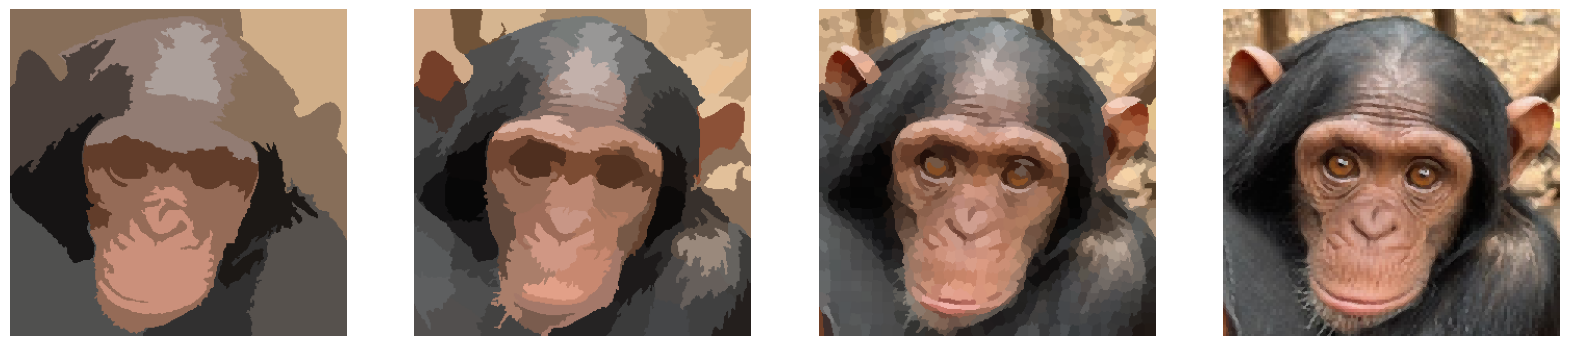

In [34]:
# Example by using SLIC superpixel before mask R-CNN
ims = []
for i in [20, 100, 1000, 10000]:
    image = load_image("images/chimp_1.png")
    seg = SLIC_segmentation(image, i)
    image_seg = get_image_seg(image, seg)  # Ensure you're passing the original image and not the segmentation output
    ims.append(image_seg)

show_images(ims)

Run


In [35]:
# Example by using SLIC superpixel before mask R-CNN
paths = [f"images/chimp_{i}.png" for i in range(1, 4)]
for image_path in paths:
    image = load_image(image_path)
    seg = SLIC_segmentation(image, 10000)
    image_seg = get_image_seg(image, seg)  # Ensure you're passing the original image and not the segmentation output
    image_isolated = get_image_isolated(image_seg)  # Perform Mask R-CNN on the original image

    show_images([image, image_seg, image_isolated])

KeyboardInterrupt: 

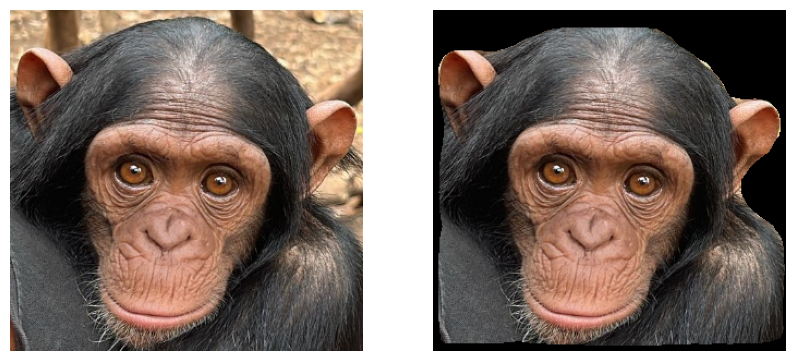

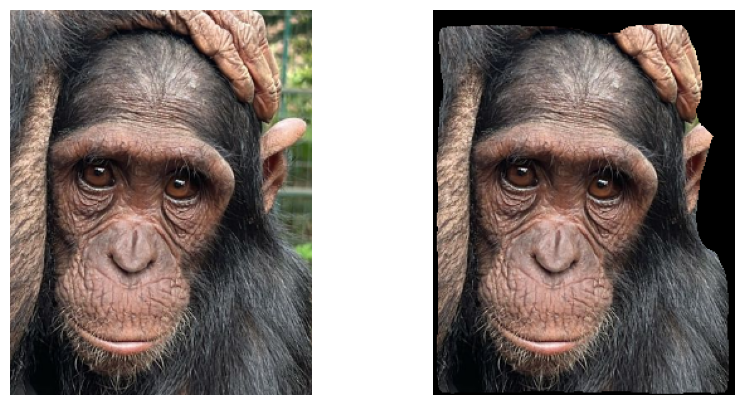

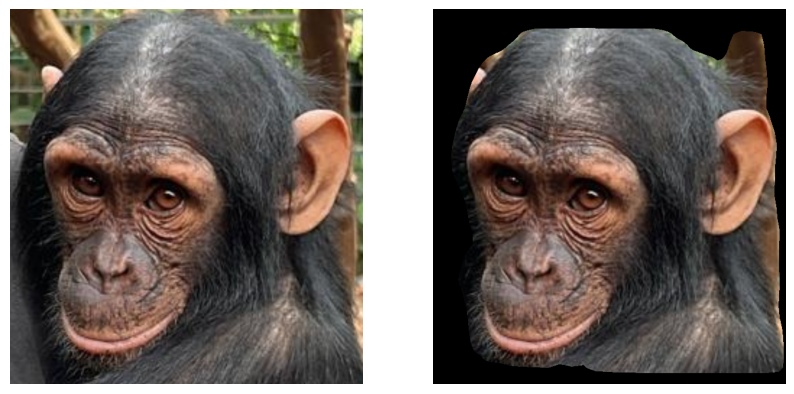

In [48]:
# Example without using SLIC superpixel before mask R-CNN
paths = [f"images/chimp_{i}.png" for i in range(1, 4)]
for image_path in paths:
    image = load_image(image_path)
    image_isolated = get_image_isolated(image)  # Perform Mask R-CNN on the original image

    show_images([image, image_isolated])

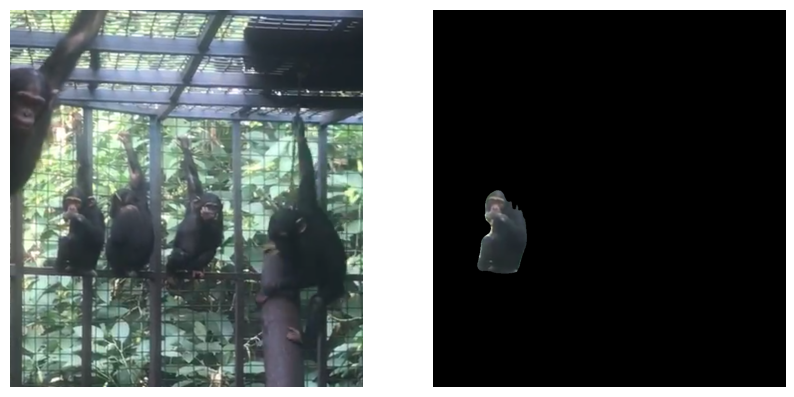

In [49]:
# Example without using SLIC superpixel before mask R-CNN
image_path = "images/2.png"
image = load_image(image_path)
image_isolated = get_image_isolated(image)  # Perform Mask R-CNN on the original image

show_images([image, image_isolated])

Trying to detect n objects

In [65]:
def isolate_n_objects(image, threshold):
    
    # Convert the image to float and normalize it to the range [0, 1]
    image = image.astype(np.float32) / 255.0

    # Convert the image to a tensor for Mask R-CNN input
    image_tensor = torchvision.transforms.functional.to_tensor(image).unsqueeze(0)

    # Perform inference with Mask R-CNN
    with torch.no_grad():
        predictions = model(image_tensor)

    # Get the masks, labels, and scores from the prediction
    masks = predictions[0]['masks'].cpu().numpy()  # Shape: [N, 1, H, W]
    scores = predictions[0]['scores'].cpu().numpy()  # Confidence scores
    labels = predictions[0]['labels'].cpu().numpy()  # Labels (if needed)

    # Initialize a copy of the image to apply the masks
    masked_image = np.zeros_like(image)  # Create an empty image with all black pixels

    # Iterate over the top n objects and apply their masks
    for idx, score in enumerate(scores):
        if (score <= threshold): continue
        mask = masks[idx, 0]  # Select the mask for the current object
        
        # Apply the mask to the original image, keeping only the pixels within the mask
        for i in range(3):  # Iterate over the RGB channels
            masked_image[:, :, i] = np.where(mask > 0.5, image[:, :, i], masked_image[:, :, i])

    # Convert masked image back to [0, 255] range for visualization
    masked_image = (masked_image * 255).astype(np.uint8)

    return masked_image

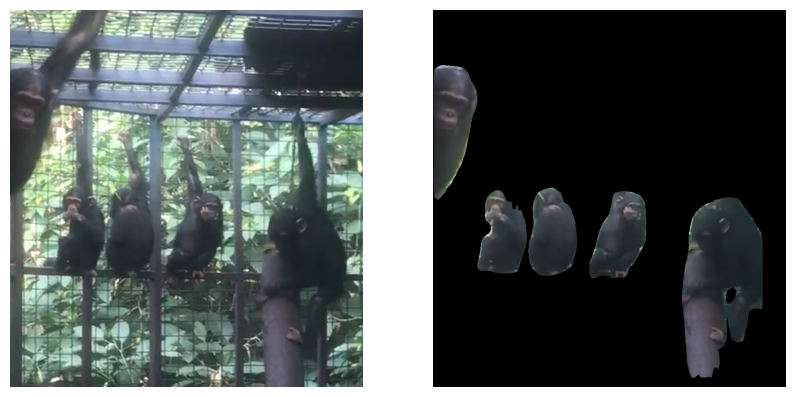

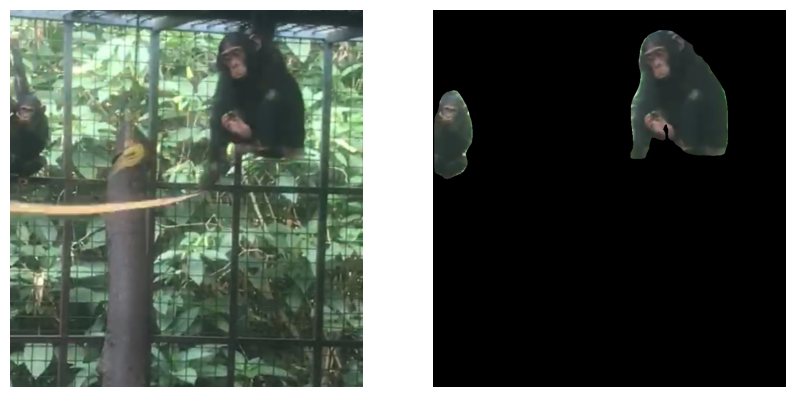

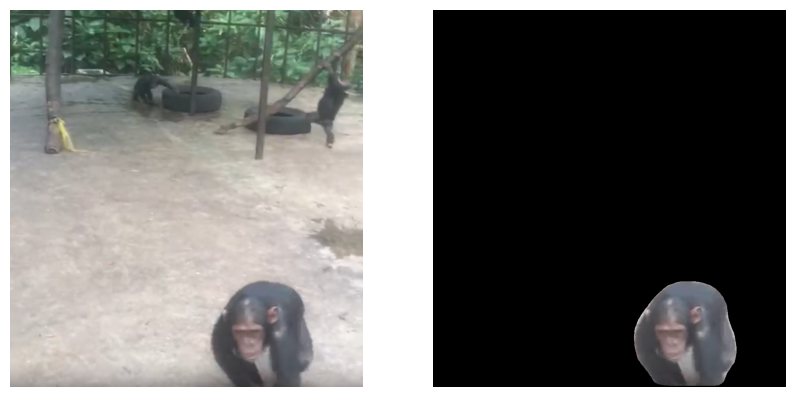

In [71]:
paths = [f"images/group_{i}.png" for i in range(1, 4)]
for image_path in paths:
    image = load_image(image_path)
    image_isolated = isolate_n_objects(image, 0.7)

    show_images([image, image_isolated])

In [12]:
# Load the COCO dataset class names (default for Mask R-CNN)
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
    'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'N/A', 'dining table', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def box_n_objects(image, threshold):
    """
    Detect and classify objects in an image, draw bounding boxes, and display class labels.
    :param image: The input image (numpy array).
    :param threshold: The confidence threshold for displaying bounding boxes.
    :return: The image with bounding boxes and labels drawn on it.
    """
    # Convert the image to float and normalize it to the range [0, 1]
    image = image.astype(np.float32) / 255.0

    # Convert the image to a tensor for Mask R-CNN input
    image_tensor = torchvision.transforms.functional.to_tensor(image).unsqueeze(0)

    # Perform inference with Mask R-CNN
    with torch.no_grad():
        predictions = model(image_tensor)

    # Get the masks, labels, scores, and bounding boxes from the prediction
    scores = predictions[0]['scores'].cpu().numpy()  # Confidence scores
    labels = predictions[0]['labels'].cpu().numpy()  # Labels (correspond to object classes)
    boxes = predictions[0]['boxes'].cpu().numpy()  # Bounding boxes

    # Initialize a copy of the original image to draw the bounding boxes
    boxed_image = (image * 255).astype(np.uint8)  # Convert image back to [0, 255] for visualization

    # Iterate over the objects and apply their bounding boxes and labels
    for idx, score in enumerate(scores):
        class_label = COCO_INSTANCE_CATEGORY_NAMES[labels[idx]]
        if score <= threshold or class_label != "person":
            continue
        
        # Get the bounding box coordinates for the current object
        box = boxes[idx].astype(int)  # Coordinates of the bounding box: [x1, y1, x2, y2]
        x1, y1, x2, y2 = box
        
        # Draw a rectangle (bounding box) around the object on the boxed_image
        cv2.rectangle(boxed_image, (x1, y1), (x2, y2), (0, 255, 0), 3)  # Red box with thickness 5

    return boxed_image


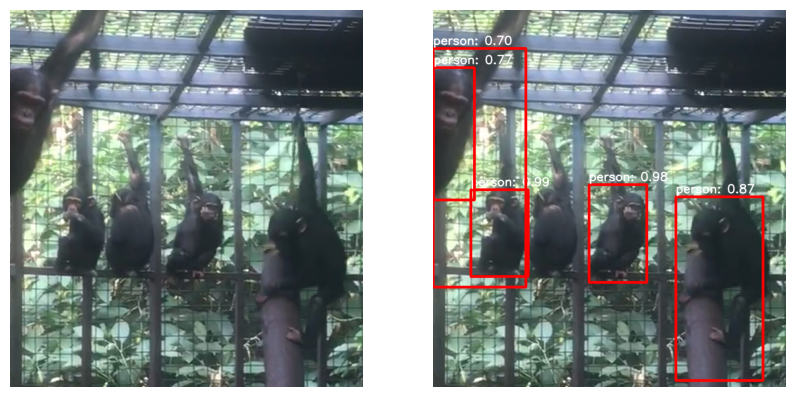

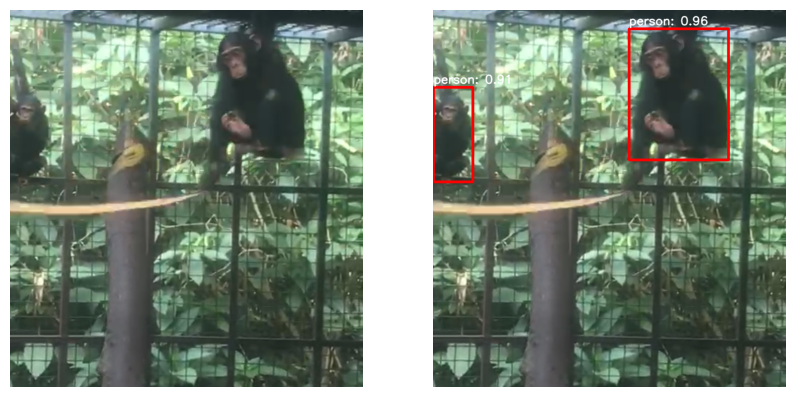

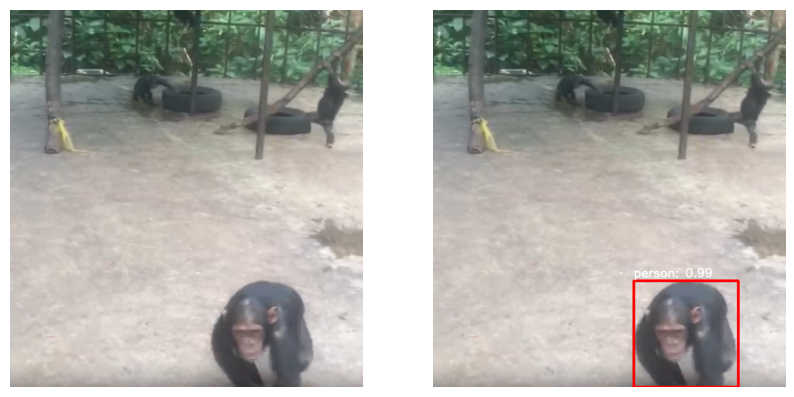

In [13]:
paths = [f"images/group_{i}.png" for i in range(1, 4)]
for image_path in paths:
    image = load_image(image_path)
    image_isolated = box_n_objects(image, 0.7)

    show_images([image, image_isolated])